# San Francisco Fires Intervention
### Simulation course project

## Introduction

The aim of this university project is to apply the main concept trated in the simulation course, in particular  simulating fire burst and fire fighters intervention in San Francisco, California in a given time window.
In this document we resume the data analysis experiment implemented and the final simulation.

We used the ["Fire Incidents"](https://data.sfgov.org/Public-Safety/Fire-Incidents/wr8u-xric) dataset provided by [San Francisco open data portal](https://datasf.org/). This 454K rows long dataset contain a lot of information (63 varaibles) about fire incident in the city of San Francisco from 2003 to present days.

## Importing package and data cleaning
In the following cell we have imported the python package needed, imported and cleaned the data.
All the date in dataset are strings, to easily manage that values in python we need to convert them in datetime type. Also the "Location" variable is a string so we split it in "Latitude" and "Longitude" variables, both numerical.

Note that the data importation and data cleaning operation can take some execution time. 

In [2]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2
pylab.rcParams['figure.figsize'] = (12,12)
matplotlib.rcParams['figure.figsize'] = (12,12)

import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from simulation_package.exponential import Exponential
from simulation_package.gamma import  Gamma
from simulation_package.normal import Normal
from simulation_package.discrete_events import SFFireSimulation
from scipy.stats import kstest
import scipy
import re

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Importing and cleaning data
def getcoordfstr(location):
    return re.findall(r"[-+]?\d*\.\d+|\d+", location)

df = pd.read_csv("SF_fire_incidents/Fire_Incidents.csv", dtype=object)
df.index = pd.to_datetime(df['Incident Date'], format= "%m/%d/%Y")

# convert date in datetime
df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'], format= "%m/%d/%Y %I:%M:%S %p")
df['Close DtTm'] = pd.to_datetime(df['Close DtTm'], format= "%m/%d/%Y %I:%M:%S %p")

# convert Location in numerical Latitude and Longitude
df['Latitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[0]) if not pd.isnull(x) else x)
df['Longitude'] = df['Location'].apply(lambda x: float(getcoordfstr(x)[1]) if not pd.isnull(x) else x)

## Variables Exploration and Distribution Fitting
In this section, as introduced before, we present the analysis made on the data, we highlight the distribution that best fit the real data. Particulary interesting for our purpose are the following variables: 

* Alarm DtTm
* Arrival DtTm
* Close DtTm
* Action Taken Primary
* Action Taken Secondary
* Action Taken Other
* Location (Latitude and Longitude)

We used the first three of that list (Alarm DtTm, Arrival DtTm, Close DtTm) to calculate the fire burst alarm intertime and the intervention time distribution.
We start by define two utility functions to calculate this values, calculate_intertime and calculate_timediff, the firt one calculate the difference between the values of given column in two near rows of the sorted dataframe. The second one, instead, calculate the difference between two column in the same row.

In [ ]:
def calculate_intertime(df, column):
    sorted_df = df.sort_values(column)
    delta = ((sorted_df[column]-sorted_df[column].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

def calculate_timediff(df, time_column1, time_column2):
    delta = ((df[time_column2]-df[time_column1].shift()).fillna(0)).apply(lambda x: x.total_seconds()).astype('int64')
    return delta

### Fire Burst Intertime Distribution

In the next cell we plot the fire burst intertimes and we show that they follow an exponential distribution. Using the maximum likelihood technique we have estimated the $\lambda$ parameter of distribution obtaining:

$$ \hat{\lambda} = \frac{n}{\sum_{i} x_i}  $$

where $\hat{\lambda}$ is an unbiased estimator of $\lambda$.

In the obtained plot we indicate the calculate intertime in the blue histogram, the scypy exponential probability distribution function with the red line and, finally, our implementation of exponantial pdf with green points. 

In [ ]:
alarm_intertime = calculate_intertime(df, 'Alarm DtTm')

exp_bins, exp_counts = Exponential(1/alarm_intertime.mean(), varred=True).pdf(10000, 500)
xs = np.linspace(0, 10000)
rv = stats.expon(0,alarm_intertime.mean())

print("Fire Burst Intertime distribution mean is {}".format(alarm_intertime.mean()))
print("Lamda = {}".format(1/alarm_intertime.mean()))
f, ax = plt.subplots()
ax.hist(alarm_intertime, bins=500, color="blue", normed=True, lw=1, alpha=0.4)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)
ax.scatter(exp_bins, exp_counts, color="green", lw=0.1, s=10)
ax.set_xlim(0, 10000)
plt.show()

In [ ]:
kstest(alarm_intertime, 'expon', args=(0,1/alarm_intertime.mean()), alternative='greater')

### Testing Antithetic Variables technique for variance reduction

In [ ]:
exp = Exponential(1, varred=False)
exp_vr = Exponential(1, varred=True)

n = 200
data = exp.rvs(n)
data_vr = exp_vr.rvs(n)
var = np.var(data)
var_vr = np.var(data_vr)

variance_ratio = ((var-var_vr)/var)
print("var {}".format(var))
print("var_vr {}".format(var_vr))
print(variance_ratio)
    
    

### Intervention Time Distribution

In the next cell we plot the intervention times (Close DtTm - Arrival DtTm) and we compare them against lognormal distribution and gamma distribution. 
We first define two function to estimate the parameters, both function use the formulas obtained applying the maximum likelihood estimation.

In [ ]:
def calculateGammaParams(data):
    mean = np.mean(data)
    s = np.log(mean) - np.mean(np.log(data))
    shape = (3-s+np.sqrt(((s-3)**2)+24*s))/(12*s)
    scale = mean/shape
    return (shape, 0, scale)

def calculateLognormalParams(data):
    mean = np.mean(np.log(data))
    scale = np.exp(mean)
    shape = np.sqrt(np.mean((np.log(data)-mean)**2))
    return (shape, 0, scale)

We calculate and plot the intervention times (blue histogram) and we compare them graphically with the gamma distribution (red) and the lognormal distribution (green).

In [ ]:
x_limit = 40000

serving_times = calculate_timediff(df, 'Arrival DtTm', 'Close DtTm')
serving_times = serving_times[(serving_times > 0) & (serving_times < x_limit)]
xs = np.linspace(0, x_limit)
gshape, gloc, gscale = calculateGammaParams(serving_times)
lnshape, lnloc, lnscale = calculateLognormalParams(serving_times)

print("Mu: {} \nVariance: {}".format(np.log(lnscale), np.power(lnshape, 2)))
mLogNormal_b, mLogNormal_c = Normal(mu=np.log(lnscale), variance=np.power(lnshape, 2), t="bm", log=True).pdf(10000, 1000)
rv_gamma = stats.gamma.pdf(xs, gshape, gloc, gscale)
rv_lognormal = stats.lognorm.pdf(xs, lnshape, lnloc, lnscale)

f, ax = plt.subplots()
ax.hist(serving_times, bins=150, color="blue", normed=True, lw=1, alpha=0.4)
ax.plot(xs, rv_gamma, color="red", lw=2)
ax.plot(xs, rv_lognormal, color="green", lw=2)
ax.scatter(mLogNormal_b, mLogNormal_c, color="green", lw=0.1, s=10)
ax.set_xlim(0, x_limit)
plt.show()
plt.clf()

In [ ]:
kstest(serving_times, 'lognorm', args=(lnshape, lnloc, lnscale), alternative='greater')

## Simulation

In [36]:
def simulate_times_diff(servers, days, k, d):
    FireSimulation = SFFireSimulation(servers, days, df)
    simulations = [FireSimulation.simulate_only_times() for _ in range(0, k)]
    data = [np.mean(x) for x in simulations if x.size > 0]
    X_mean = np.mean(data)
    S_square = np.var(data)
    while (np.sqrt(S_square)/np.sqrt(k)) > d:
        result = FireSimulation.simulate_only_times()
        if result.size > 0:
            mean = np.mean(result)
            old_mean = X_mean
            X_mean = X_mean + ((mean- X_mean))/k
            if k == 1:
                S_square = 0
            else:
                S_square = (1-(1/k))*S_square+(k+1)*(X_mean-old_mean)**2
            k+=1
    
    return k, X_mean, np.sqrt(S_square)

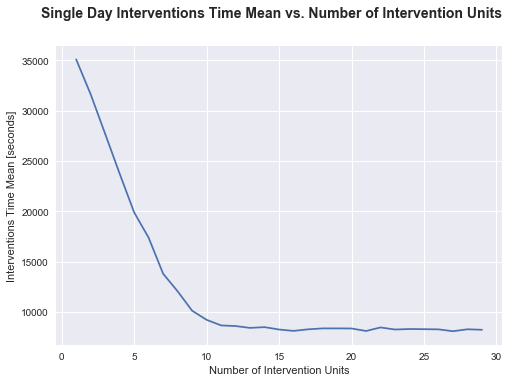

In [37]:
k = 100
d = 500
x = range(1, 30)
diff_means = [simulate_times_diff(i, 1, k, d)[1] for i in x]

f, ax = plt.subplots()
f.suptitle('Single Day Interventions Time Mean vs. Number of Intervention Units', fontsize=14, fontweight='bold')
ax.plot(x, diff_means)
ax.set_xlabel('Number of Intervention Units')
ax.set_ylabel('Interventions Time Mean [seconds]')
plt.show()

## Other stuff

In [ ]:
box = df['Box']
vc_box = box.value_counts(dropna=True)
idx = vc_box.index
x = range(len(idx))
print(len(idx))
plt.bar(x, vc_box)
plt.xticks(x, idx, rotation=90)
plt.show()

In [ ]:
#### Normal/Lognormal implementation
normal_bm  = Normal(mu=0.0, variance=0.25, t="bm", log=True)
pdf_bm_x, pdf_bm_y = normal_bm.pdf(30000, 300)

normal_approx = Normal(t="approx", log=False)
pdf_approx_x, pdf_approx_y = normal_approx.pdf(30000, 150)

plt.scatter(pdf_bm_x, pdf_bm_y, color="blue", s=10)
plt.scatter(pdf_approx_x, pdf_approx_y, color="green", s=10)
plt.show()

In [ ]:
civilian_fatalities = df['Number of Sprinkler Heads Operating'].value_counts(normalize=True)
print(civilian_fatalities[civilian_fatalities<300])
plt.bar(civilian_fatalities[civilian_fatalities<300].index.astype('int32'), civilian_fatalities[civilian_fatalities<300], 0.35, color='r')

In [ ]:
x = df['Action Taken Secondary'].value_counts(normalize=True)
#np.random.choice(x.index, 1, p=x)
x

In [ ]:
prop_loss = (df['Estimated Contents Loss'].dropna().astype('float'))
print(max(prop_loss))
print(min(prop_loss))

xs = np.linspace(0, 4000)
rv = stats.expon(0,prop_loss.mean())
print(prop_loss.mean())

ax = plt.subplot(111)
ax.hist(prop_loss, bins=150)
ax.plot(xs, rv.pdf(xs), color="red", lw=2)

ax.set_ylim([0, 100])

plt.show()

In [ ]:
sprinkler = df['Number of Sprinkler Heads Operating'].dropna().astype('int64').value_counts(normalize=True)
print(sprinkler)
print(np.mean(sprinkler.index))
geom_values = pd.Series(np.random.geometric(p=(1/np.mean(sprinkler.index)), size=1000))
x = geom_values.value_counts(normalize=True)
plt.plot(sprinkler.index, sprinkler)
plt.plot(x.index, x)